# Real Estate Transactions Analysis

**Train a model with real estate data using Sagemaker built-in XGBoost algorithm**

## Import Libraries and Load Dataset

In [1]:
# Import necessary libraries
import boto3
import pandas as pd
from sklearn.model_selection import train_test_split
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
import scipy.sparse as sp
import pandas as pd

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## Data Preparation

Shuffling and splitting your dataset into training, validation, and test sets.


In [2]:
# Load dataset
df_final = pd.read_csv('data/final_dataset.csv')

# Define the target feature and predictors
target_feature = 'actual_worth'
X = df_final.drop(columns=[target_feature])
y = df_final[target_feature]

# Display information about the transformed dataset
X.info()

# Split the data into training and testing sets with 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the test set into testing and validation sets evenly
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760814 entries, 0 to 760813
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   trans_group_en        760814 non-null  object 
 1   procedure_name_en     760814 non-null  object 
 2   property_sub_type_en  760814 non-null  object 
 3   property_usage_en     760814 non-null  object 
 4   reg_type_en           760814 non-null  object 
 5   area_name_en          760814 non-null  object 
 6   master_project_en     672455 non-null  object 
 7   nearest_landmark_en   676553 non-null  object 
 8   nearest_metro_en      590408 non-null  object 
 9   nearest_mall_en       590029 non-null  object 
 10  rooms_en              760814 non-null  object 
 11  has_parking           760814 non-null  int64  
 12  procedure_area        760814 non-null  float64
dtypes: float64(1), int64(1), object(11)
memory usage: 75.5+ MB


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define categorical and numerical values
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough', 
    verbose=True)

In [4]:
# transform X_train and X_val
preprocessor.fit(X)
X_train_pre = preprocessor.transform(X_train)
X_val_pre = preprocessor.transform(X_val)
X_test_pre = preprocessor.transform(X_test)

[ColumnTransformer] ....... (1 of 2) Processing encoder, total=   2.1s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


In [5]:
# Make y_train a column vector
y_train_pre = y_train.to_numpy().reshape(len(y_train), 1)
y_train_pre_sparse = sp.csr_matrix(y_train_pre)

y_val_pre = y_val.to_numpy().reshape(len(y_val), 1)
y_val_pre_sparse = sp.csr_matrix(y_val_pre)

In [6]:
# Concatenate X and y column-wise since for sagemaker train and val data should be with labels
train_new = sp.hstack([y_train_pre_sparse, X_train_pre])
val_new = sp.hstack([y_val_pre_sparse, X_val_pre])

In [7]:
# Check the shape
print("Number of columns in X_test_pre:", X_test_pre.shape[1])
print("Number of columns in train_new:", train_new.shape[1])
print("Number of columns in val_new:", val_new.shape[1])

Number of columns in X_test_pre: 292
Number of columns in train_new: 293
Number of columns in val_new: 293


### Save files locally

In [8]:
df_train = pd.DataFrame(data=sp.csr_matrix.todense(train_new))

In [9]:
df_val = pd.DataFrame(data=sp.csr_matrix.todense(val_new))

In [10]:
df_test = pd.DataFrame(data=sp.csr_matrix.todense(X_test_pre))

## Upload Data to S3

In [11]:
# Setup the initial variables and SageMaker session
bucket = 'dld-transactions-project'
prefix = 'XGBoost-Regressor-matrix'

In [12]:
# Define S3 object keys for the data and model output
train_key = f'{prefix}/train/train.csv'
validation_key = f'{prefix}/validation/validation.csv'
test_key = f'{prefix}/test/test.csv'
model_output_key = f'{prefix}/artifacts'

In [13]:
# Construct full S3 paths for printing and reference
s3_train_path = f's3://{bucket}/{train_key}'
s3_validation_path = f's3://{bucket}/{validation_key}'
s3_test_path = f's3://{bucket}/{test_key}'
s3_model_output_path = f's3://{bucket}/{model_output_key}'

In [14]:
# Print S3 paths for verification
print(f'Training artifacts will be uploaded to: {s3_model_output_path}')
print(f'Training data path: {s3_train_path}')
print(f'Validation data path: {s3_validation_path}')
print(f'Test data path: {s3_test_path}')

Training artifacts will be uploaded to: s3://dld-transactions-project/XGBoost-Regressor-matrix/artifacts
Training data path: s3://dld-transactions-project/XGBoost-Regressor-matrix/train/train.csv
Validation data path: s3://dld-transactions-project/XGBoost-Regressor-matrix/validation/validation.csv
Test data path: s3://dld-transactions-project/XGBoost-Regressor-matrix/test/test.csv


In [15]:
# Function to save DataFrame to .npz and upload to S3
def upload_data_to_s3(data_frame, local_file_name, object_key):
    data_frame.to_csv(local_file_name, index=False)
    boto3.Session().resource('s3').Bucket(bucket).Object(object_key).upload_file(local_file_name)
    print(f'Uploaded {local_file_name} to s3://{bucket}/{object_key}')

In [16]:
# upload to S3
upload_data_to_s3(df_train, 'preprocessed_data/train.csv', train_key)

Uploaded preprocessed_data/train.csv to s3://dld-transactions-project/XGBoost-Regressor-matrix/train/train.csv


In [17]:
# upload to S3
upload_data_to_s3(df_val, 'preprocessed_data/val.csv', validation_key)

Uploaded preprocessed_data/val.csv to s3://dld-transactions-project/XGBoost-Regressor-matrix/validation/validation.csv


In [18]:
# upload to S3
upload_data_to_s3(df_test, 'preprocessed_data/test.csv', test_key)

Uploaded preprocessed_data/test.csv to s3://dld-transactions-project/XGBoost-Regressor-matrix/test/test.csv


## Training Algorithm Docker Image

In [16]:
sagemaker_session = Session(default_bucket=bucket)
region = boto3.Session().region_name
role = get_execution_role()

In [17]:
# Obtain a reference to the XGBoost container image (sagemaker built-in algorithm)

container = sagemaker.image_uris.retrieve('xgboost',region,'1.7-1') # Latest version of XGboost
print (f'Using XGBoost Container {container}')

Using XGBoost Container 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1


## Build Hyperparameter Tuning Job

In [20]:
from sagemaker.estimator import Estimator

job_name = "dld-transactions-xgboost-final" # Training job name

# Creating the estimator
estimator = Estimator(
    sagemaker_session = sagemaker_session,
    image_uri = container,
    base_job_name = job_name,
    role = role,
    output_path=s3_model_output_path,
    instance_type = 'ml.m4.xlarge',
    instance_count = 3,
    # use_spot_instances = True,
    # max_run = 4000,
    # max_wait = 8000
)

In [122]:
# Instead of parsing a list of values for hyperparameter option, 
# the search grid is set to declare a range space where the tuning job itself 
# will be allowed to select values to test.

from sagemaker.tuner import ContinuousParameter, IntegerParameter

search_grid = {
    "alpha": ContinuousParameter(1, 20),
    "eta": ContinuousParameter(0.05, 0.5),
    "max_depth": IntegerParameter(5, 15),
    "colsample_bytree": ContinuousParameter(0.3, 0.9),
}


In [123]:
# Create the hyperparameter tuning job class

from sagemaker.tuner import HyperparameterTuner

# Estimator objective and evaluation metric to be applied
estimator.set_hyperparameters(
    eval_metric = "rmse",
    objective = "reg:squarederror",
    seed = 42,
    num_round = 400,
    rate_drop = 0.3
)

# Creating a tuner class
hyperparam_tuner = HyperparameterTuner(
    estimator = estimator,
    early_stopping_type = "Auto",
    objective_metric_name = "validation:rmse",
    strategy = "Bayesian", # The HyperparameterTuner() class optimizes the searching of values to be tested on each model training using Bayesian Search. This method treats this whole value searching task as a regression problem.
    objective_type = "Minimize",
    max_jobs = 200,
    max_parallel_jobs = 3,
    hyperparameter_ranges = search_grid
)

In [124]:
# Start execution
hyperparam_tuner.fit(
    wait = False,
    job_name = job_name,
    inputs = {
        "train": TrainingInput(s3_train_path, content_type = "csv"), 
        "validation": TrainingInput(s3_validation_path, content_type = "csv")
    }
)

INFO:sagemaker:Creating hyperparameter tuning job with name: dld-transactions-xgboost-final


In [21]:
import boto3

# Create client from sagemaker service
client = boto3.Session().client("sagemaker")

# Get tuning job description
tuner_job_info = client.describe_hyper_parameter_tuning_job(
  HyperParameterTuningJobName = job_name
)

# Get name from the best training job among all jobs performed
best_job_name = tuner_job_info["BestTrainingJob"]["TrainingJobName"]

# Get best job description
best_job_info = client.describe_training_job(
  TrainingJobName = best_job_name
)

## Analyze SageMaker Tuning results

In [31]:
from sagemaker.tuner import HyperparameterTuner
hyperparam_tuner = HyperparameterTuner.attach(job_name)

In [32]:
# define a boolean that will be used to sort the data in the right order, depending on the tuning direction:
is_ascending = False    
print('for this tuner, objective is to ' + hyperparam_tuner.objective_type)

for this tuner, objective is to Minimize


In [33]:
results = hyperparam_tuner.analytics().dataframe()

# Only use completed training jobs
# results = results[results.TrainingJobStatus == "Completed"]
num_iterations = results.shape[0]

if (num_iterations >= 1):
    
    # sort
    results = (results[~results.FinalObjectiveValue.isnull()]
               .sort_values(by='TrainingStartTime', ascending=True).reset_index(drop=True))

    results['cumulative'] = results['FinalObjectiveValue'].cummin()

    best_job = results.sort_values(by='FinalObjectiveValue',
                                   ascending=not is_ascending)['TrainingJobName'].values[0]
    print('{} iterations'.format(len(results)))
    print('best job: {}'.format(best_job))

    # show top 5 best iterations
    print(results.sort_values(by='FinalObjectiveValue', ascending=not is_ascending).head(5))
else:
    print(f'Job {jobname} has no tuning results to analyze yet.')

200 iterations
best job: dld-transactions-xgboost-v6-130-d65f288a
        alpha  colsample_bytree       eta  max_depth  \
129  8.225892          0.710259  0.208911       11.0   
156  8.188741          0.708946  0.207558       11.0   
183  8.060843          0.711455  0.209305       11.0   
184  7.975353          0.704611  0.209737       11.0   
190  8.042741          0.705662  0.209814       11.0   

                              TrainingJobName TrainingJobStatus  \
129  dld-transactions-xgboost-v6-130-d65f288a           Stopped   
156  dld-transactions-xgboost-v6-157-e4b98763           Stopped   
183  dld-transactions-xgboost-v6-184-a9fe0425           Stopped   
184  dld-transactions-xgboost-v6-185-66d94757           Stopped   
190  dld-transactions-xgboost-v6-191-97e6cb5d           Stopped   

     FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
129         280355.87500 2024-04-24 13:13:22+00:00 2024-04-24 13:14:08+00:00   
156         284176.25000 2024-04-2

In [34]:
results[:5]

,alpha,colsample_bytree,eta,max_depth,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,cumulative
0,6.176000,0.865021,0.197074,11.0,dld-transactions-xgboost-v6-003-c9a4f50d,Stopped,300380.31250,2024-04-24 12:06:08+00:00,2024-04-24 12:09:35+00:00,207.0,300380.3125
1,6.099982,0.706735,0.421171,10.0,dld-transactions-xgboost-v6-002-29dd7e04,Stopped,300380.34375,2024-04-24 12:06:31+00:00,2024-04-24 12:09:19+00:00,168.0,300380.3125
2,11.751119,0.683698,0.171447,13.0,dld-transactions-xgboost-v6-001-dd9e4370,Completed,300380.31250,2024-04-24 12:06:41+00:00,2024-04-24 12:10:25+00:00,224.0,300380.3125
3,14.568682,0.424082,0.297383,13.0,dld-transactions-xgboost-v6-004-85fec6ae,Stopped,300378.68750,2024-04-24 12:09:43+00:00,2024-04-24 12:10:34+00:00,51.0,300378.6875
4,4.140963,0.863324,0.182737,20.0,dld-transactions-xgboost-v6-006-052e00eb,Stopped,300378.84375,2024-04-24 12:10:37+00:00,2024-04-24 12:12:12+00:00,95.0,300378.6875


### Convergence speed

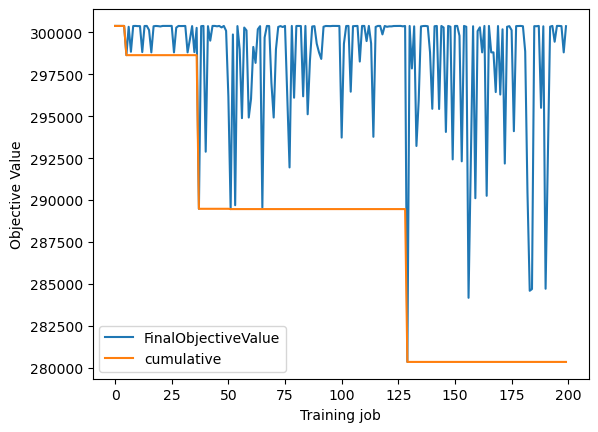

In [35]:
# target vs iteration

ax = (results.sort_values(by='TrainingStartTime', ascending=True)
 .reset_index()[['FinalObjectiveValue', 'cumulative']].plot())
ax.set_xlabel('Training job')
ax.set_ylabel('Objective Value');

This allows us to display epoch-by-epoch performance of all iterations and highlight the best iteration

In [31]:
print('Best Job: {}'.format(best_job_name))
print('Status: {}'.format(best_job_info['TrainingJobStatus']))
print('Metric Value: {}'.format(best_job_info['FinalMetricDataList'][-1]['Value']))
print('Artifact Path: {}'.format(best_job_info['ModelArtifacts']['S3ModelArtifacts']))

Best Job: dld-transactions-xgboost-final-064-e87a47ee
Status: Completed
Metric Value: 369122.15625
Artifact Path: s3://dld-transactions-project/XGBoost-Regressor-matrix/artifacts/dld-transactions-xgboost-final-064-e87a47ee/output/model.tar.gz


In [36]:
print('Best Job Hyperparameters: {}'.format(best_job_info['HyperParameters']))

Best Job Hyperparameters: {'_tuning_objective_metric': 'validation:rmse', 'alpha': '20.0', 'colsample_bytree': '0.43498850099479036', 'eta': '0.15006744105393405', 'eval_metric': 'rmse', 'max_depth': '15', 'num_round': '400', 'objective': 'reg:squarederror', 'rate_drop': '0.3', 'seed': '42'}


In [118]:
# Code below works only for jobs with Completed status, due to enabled early stopping the best job might be not completed:

# predictor = hyperparam_tuner.deploy(    
#     instance_type = 'ml.m4.xlarge',
#     initial_instance_count = 3,
#     endpoint_name = job_name
# )

## Build Model with Tuned Hyperparameters

In [33]:
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_name = 'inference-pipeline-' + timestamp_prefix
endpoint_name = 'xgboost-inference-pipeline-ep-' + timestamp_prefix


estimator = sagemaker.estimator.Estimator(
    sagemaker_session = sagemaker_session,
    image_uri = container,
    base_job_name = model_name,
    role = role,
    output_path=s3_model_output_path,
    instance_type = 'ml.m4.xlarge',
    instance_count = 1
)

In [37]:
estimator.set_hyperparameters(
    max_depth=15,
    eta=0.15006744105393405,
    num_round=400,
    colsample_bytree=0.43498850099479036,
    objective="reg:squarederror",
    rate_drop=0.3,
    seed=42
)

In [38]:
estimator.hyperparameters()

{'max_depth': 15,
 'eta': 0.15006744105393405,
 'num_round': 400,
 'colsample_bytree': 0.43498850099479036,
 'objective': 'reg:squarederror',
 'rate_drop': 0.3,
 'seed': 42}

### Specify Training Data Location and Optionally, Validation Data Location

In [39]:
# content type can be libsvm or csv for XGBoost
training_input_config = sagemaker.session.TrainingInput(
    s3_data=s3_train_path,
    content_type='csv',
    s3_data_type='S3Prefix')

validation_input_config = sagemaker.session.TrainingInput(
    s3_data=s3_validation_path,
    content_type='csv',
    s3_data_type='S3Prefix'
)

data_channels = {'train': training_input_config, 'validation': validation_input_config}


In [40]:
print(training_input_config.config)
print(validation_input_config.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://dld-transactions-project/XGBoost-Regressor-matrix/train/train.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://dld-transactions-project/XGBoost-Regressor-matrix/validation/validation.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}


### Train the model

In [41]:
estimator.fit(data_channels)

INFO:sagemaker:Creating training-job with name: inference-pipeline-2024-05-01-11-42-36-2024-05-01-11-45-21-939


2024-05-01 11:45:22 Starting - Starting the training job...
2024-05-01 11:45:36 Starting - Preparing the instances for training...
2024-05-01 11:46:19 Downloading - Downloading input data......
2024-05-01 11:47:20 Downloading - Downloading the training image......
2024-05-01 11:48:05 Training - Training image download completed. Training in progress..[2024-05-01 11:48:21.793 ip-10-0-148-37.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-05-01 11:48:21.829 ip-10-0-148-37.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-05-01:11:48:22:INFO] Imported framework sagemaker_xgboost_container.training
[2024-05-01:11:48:22:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2024-05-01:11:48:22:INFO] No GPUs detected (normal if no gpus installed)
[2024-05-01:11:48:22:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-05-01:11:48:22:INFO] Determined 0 GPU(s) available on the 

## Deploy Model

In [42]:
# Ref: http://sagemaker.readthedocs.io/en/latest/estimators.html
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m4.xlarge',
                             endpoint_name = endpoint_name)

# INFO:sagemaker:Creating model with name: inference-pipeline-2024-04-30-09-19-36-2024-04-30-10-51-09-219
# INFO:sagemaker:Creating endpoint-config with name xgboost-inference-pipeline-ep-2024-04-30-09-19-36
# INFO:sagemaker:Creating endpoint with name xgboost-inference-pipeline-ep-2024-04-30-09-19-36

INFO:sagemaker:Creating model with name: inference-pipeline-2024-05-01-11-42-36-2024-05-01-13-19-15-453
INFO:sagemaker:Creating endpoint-config with name xgboost-inference-pipeline-ep-2024-05-01-11-42-36
INFO:sagemaker:Creating endpoint with name xgboost-inference-pipeline-ep-2024-05-01-11-42-36


--------!

## Run Predictions


In [18]:
# endpoint_name='xgboost-inference-pipeline-ep-2024-05-01-11-42-36'

In [19]:
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

In [20]:
from sagemaker.serializers import CSVSerializer
predictor.serializer = CSVSerializer()

In [21]:
from sagemaker.deserializers import CSVDeserializer
predictor.deserializer = CSVDeserializer()

In [25]:
# Read test data from file

# arr_test = X_test_pre.toarray()
# type(arr_test)

test_data = pd.read_csv('preprocessed_data/test.csv')
test_data_arr = test_data.to_numpy()
test_data_arr.shape

In [27]:
y_predict_1 = predictor.predict(test_data_arr[0:5000])

In [28]:
# transform predictions into list of floats
y_predict_1 = pd.Series(y_predict_1, name='actual_worth').apply(lambda x: x[0]).astype('float64')

In [29]:
y_test[0:5000]

758471     853603.0
299046    1103631.0
736791    1188790.0
736156     330000.0
294085     980888.0
            ...    
298283     431310.0
664693    1359406.0
584893     392096.0
545725    2275888.0
261225    1206178.0
Name: actual_worth, Length: 5000, dtype: float64

In [30]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

k = X_test_pre.shape[1]
n = len(y_predict_1)
RMSE = float(format(np.sqrt(mean_squared_error(y_test[0:5000], y_predict_1)),'.3f'))
MSE = mean_squared_error(y_test[0:5000], y_predict_1)
MAE = mean_absolute_error(y_test[0:5000], y_predict_1)

# coefficient of determination - how much variance can be explained by the given features
r2 = r2_score(y_test[0:5000], y_predict_1)
# adjusted R-squared - adjusts for the degrees of freedom, effectively penalizing the addition of more predictors to a model
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 343734.754 
MSE = 118153581243.19948 
MAE = 211480.66236152343 
R2 = 0.8704294799799139 
Adjusted R2 = 0.8623915382238346


In [32]:
# Run predictions locally

# ! pip install xgboost

# import tarfile
# import pickle as pkl
# import xgboost as xgb


# # download the model artifact from AWS S3
# # !aws s3 cp s3://dld-transactions-project/XGBoost-Regressor-matrix/artifacts/inference-pipeline-2024-04-25-14-16-39-2024-04-25-14-17-02-656/output/model.tar.gz .

# #opens the downloaded model artifcat and loads it as 'model' variable
# tar = tarfile.open('model.tar.gz')
# tar.extractall()
# tar.close()

# model = xgb.Booster()
# model.load_model('xgboost-model')

# dtest = xgb.DMatrix(X_test_pre)

# y_predict = model.predict(dtest)
# print(y_predict)